# nCoV-2019
<img src='https://ars.els-cdn.com/content/image/3-s2.0-B9780443073670000409-f040-001-9780443073670.jpg'>

<b>Overview:</b> <br>
Model the growth of the nCoV-2019 Corona Virus infections in mainland China and outside the mainland.

<b>Data Source:</b> <br>
https://en.m.wikipedia.org/wiki/Timeline_of_the_2019–20_Wuhan_coronavirus_outbreak <br>
http://www.nhc.gov.cn/xcs/yqtb/list_gzbd.shtml <br>
https://www.thelancet.com/pb-assets/Lancet/pdfs/S0140673620302117.pdf <br>
Clinical outcome (99 Cases)
<li> Remained in hospital 57 (58%)
<li> Discharged 31 (31%)
<li> Died 11 (11%)

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Tue Jan 28 08:19:13 2020
"""
import datetime as dt
import warnings
warnings.filterwarnings("ignore")
#import packages
import pandas as pd
import numpy as np
import xlrd
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import pandas_datareader as pdr
from tabulate import tabulate
from matplotlib import style
from matplotlib.pylab import rcParams
style.use('fivethirtyeight')
#style.use('ggplot')

In [2]:
df_csv=pd.read_csv(r'corona2.csv')
df_xls=pd.read_excel(r'Corona.xlsx')
#Eliminating sparse data
# df=df_xls[7:]

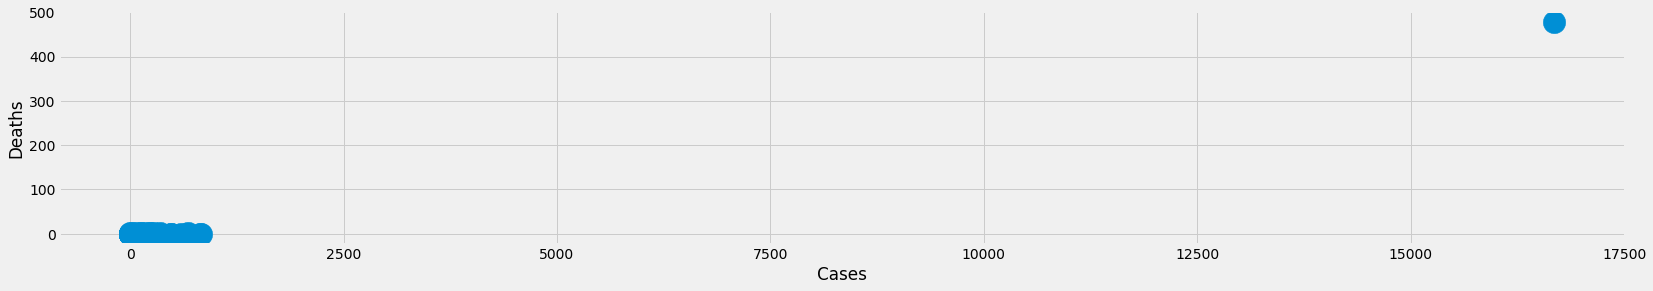

In [3]:
rcParams['figure.figsize'] = 25,4
df_csv.plot.scatter(x='Cases', y='Deaths', s=500)

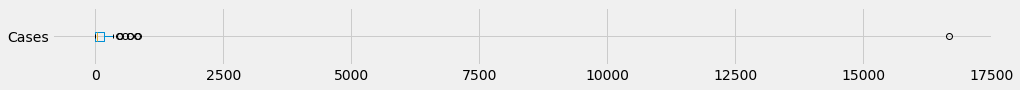

In [4]:
rcParams['figure.figsize'] =15,1
df_csv.boxplot(column='Cases', vert=False)

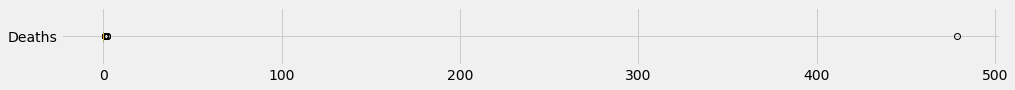

In [5]:
rcParams['figure.figsize'] =15,1
df_csv.boxplot(column='Deaths', vert=False)

In [6]:
df_csv_sorted = df_csv.sort_values(by='Cases', ascending=False)
print('Top 5 Regions by Cases')
df_csv_sorted.head(5)

Top 5 Regions by Cases


,REGION,Cases,Deaths,Notes,Links
0,Hubei province\n(including Wuhan),16678,479,"1,809 serious, 711 critical",Source
1,Zhejiang province,829,0,"43 serious, 15 critical",Source
2,Guangdong province,813,0,"60 serious, 26 critical",Source
3,Henan province,675,2,"39 serious, 15 critical",Source
31,Undisclosed,675,0,NaN,Source


In [7]:
# df=df.reset_index(drop=True)

In [8]:
# df_xls=df_xls[:22]

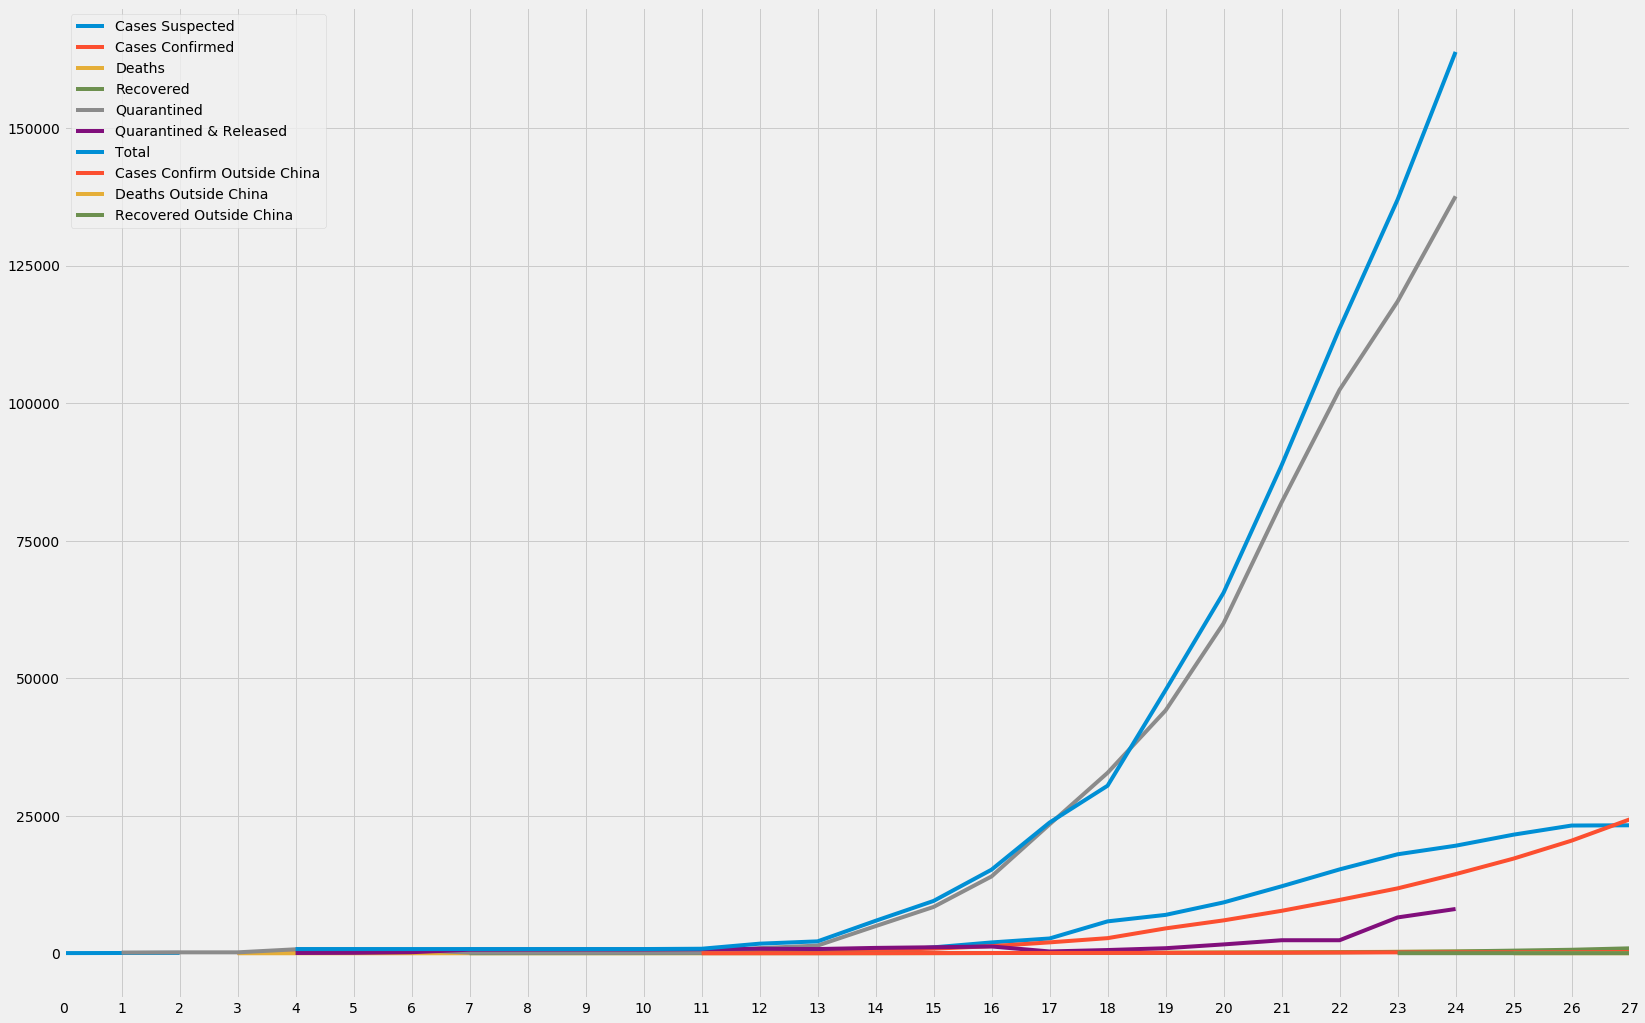

In [9]:
rcParams['figure.figsize'] = 25,17
df_xls.plot(xticks=df_xls.index)

In [10]:
df=df_xls.fillna(0)
df['Cases_pct'] = df['Cases Confirmed'].pct_change()
df['Deaths_pct'] = df['Deaths'].pct_change()
df['Cases_new'] = df['Cases Confirmed'].diff()
df['Deaths_new'] = df['Deaths'].diff()
df

,Date,Cases Suspected,Cases Confirmed,Deaths,Recovered,Quarantined,Quarantined & Released,Total,Source,Cases Confirm Outside China,Deaths Outside China,Recovered Outside China,Cases_pct,Deaths_pct,Cases_new,Deaths_new
0,2019.12.31,27.0,0.0,0.0,0.0,0.0,0.0,0.0,[3],0.0,0.0,0.0,NaN,NaN,NaN,NaN
1,2020.01.03,44.0,0.0,0.0,0.0,121.0,0.0,0.0,[4],0.0,0.0,0.0,NaN,NaN,0.0,0.0
2,2020.01.05,59.0,0.0,0.0,0.0,163.0,0.0,0.0,[5],0.0,0.0,0.0,NaN,NaN,0.0,0.0
3,2020.01.10,0.0,41.0,1.0,0.0,163.0,0.0,0.0,[6],0.0,0.0,0.0,inf,inf,41.0,1.0
4,2020.01.11,0.0,41.0,1.0,0.0,717.0,46.0,763.0,[7],0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
5,2020.01.12,0.0,41.0,1.0,0.0,687.0,76.0,763.0,[8],0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
6,2020.01.13,0.0,41.0,1.0,0.0,576.0,187.0,763.0,[9],0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
7,2020.01.15,0.0,41.0,2.0,7.0,119.0,644.0,763.0,[10],0.0,0.0,0.0,0.000000,1.000000,0.0,1.0
8,2020.01.16,0.0,45.0,2.0,12.0,98.0,665.0,763.0,[11],0.0,0.0,0.0,0.097561,0.000000,4.0,0.0
9,2020.01.17,0.0,62.0,2.0,15.0,82.0,681.0,763.0,[12],0.0,0.0,0.0,0.377778,0.000000,17.0,0.0


CONFIRMED CASES - Comparison


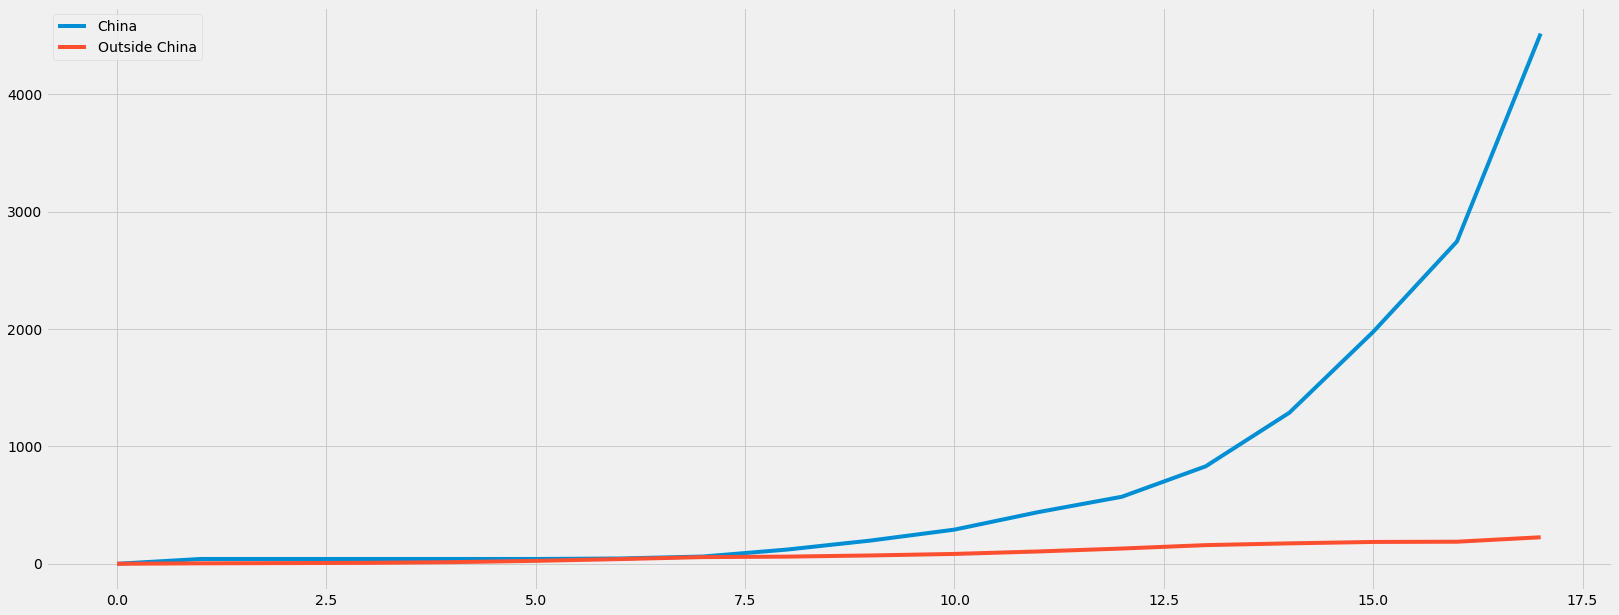

CONFIRMED CASES - Comparison of First 10 Days


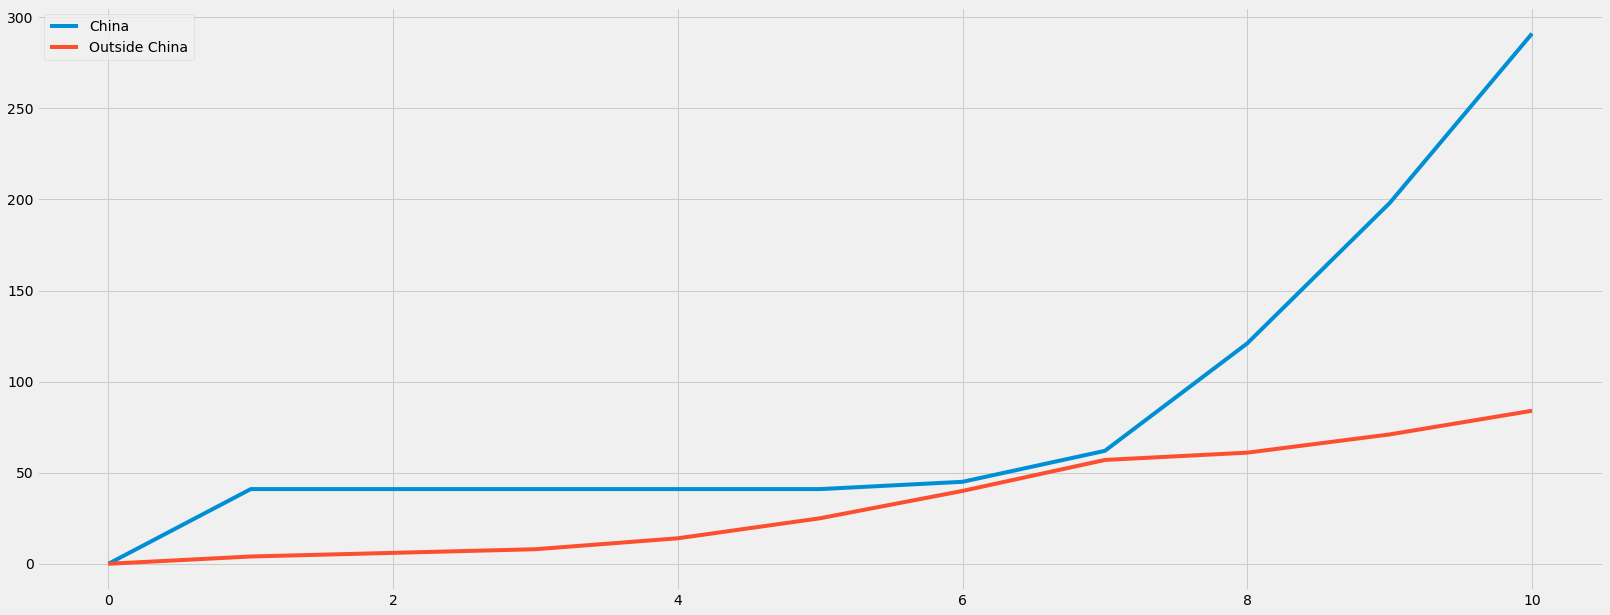

In [11]:
df_sc = df['Cases Suspected']
df_cc = df['Cases Confirmed']
df_cco = df['Cases Confirm Outside China']
print('CONFIRMED CASES - Comparison')
cco = np.array(df_cco[10:])
cc = np.array(df_cc[2:20])
rcParams['figure.figsize'] = 25,10
plt.plot(cc, label = 'China')
plt.plot(cco, label = 'Outside China')
plt.legend()
plt.show()
print('CONFIRMED CASES - Comparison of First 10 Days')
cco = np.array(df_cco[10:21])
cc = np.array(df_cc[2:13])
rcParams['figure.figsize'] = 25,10
plt.plot(cc, label = 'China')
plt.plot(cco, label = 'Outside China')
plt.legend()
plt.show()

Percentage of cases outside China
*********************************
Current percentage = 0.9%


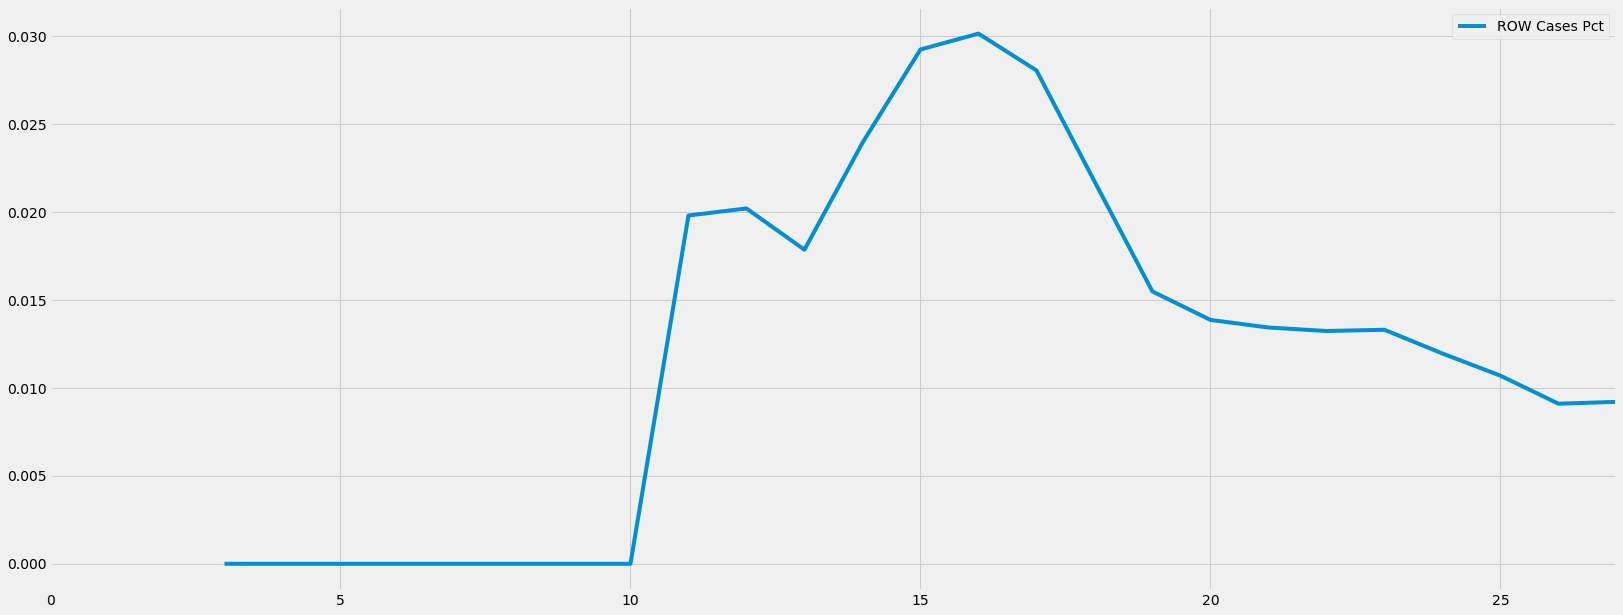

In [12]:
print('Percentage of cases outside China')
print('*********************************')
df['Total Cases'] = df['Cases Confirmed']+df['Cases Confirm Outside China']
df['China Cases Pct'] = df['Cases Confirmed']/df['Total Cases']
df['ROW Cases Pct'] = df['Cases Confirm Outside China']/df['Total Cases']
row_ratio = df['ROW Cases Pct'].tail(1).values[0]
print('Current percentage = {:0.1%}'.format(row_ratio))
df['ROW Cases Pct'].plot()
plt.legend()
plt.show()

RECOVERIES vs. FATALITIES


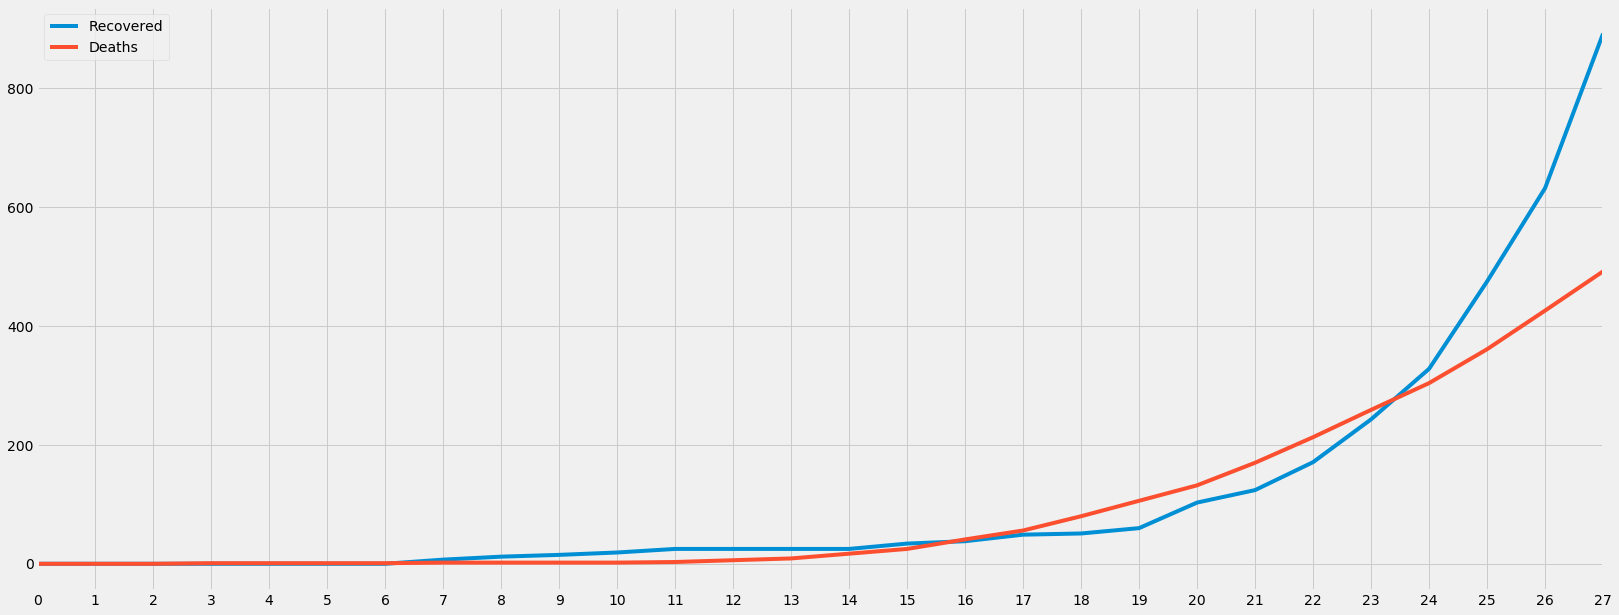

In [13]:
df_d = df['Deaths']
df_r = df['Recovered']
print('RECOVERIES vs. FATALITIES')
df_r.plot(xticks=df.index)
df_d.plot(xticks=df.index)
plt.legend()
plt.show()

In [14]:
def exponential_fit(x, a, b, c):
    return a*np.exp(b*x) + c

def linear_fit(x, m, c):
    return (m*x) + c

def sig_fit(x, a, b):
    return (1 / (1 + np.exp(-b*(x-a))))
     

In [15]:
def proj(dat, no, d=10000000):
    n=no
    data = dat
    y=np.array(dat)
    x=np.array(dat.index)
    
    #Fit Data
    #Dropped the last data point in the fit, and used it as a test for the fit
    fitting_parameters, covariance = curve_fit(exponential_fit, x[:n], y[:n])
    a, b, c = fitting_parameters
    
    
    residuals = y[:n]- exponential_fit(x[:n], *fitting_parameters)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y[:n]-np.mean(y[:n]))**2)
    r_2 = 1 - (ss_res / ss_tot)
    
    print('a = ',a)
    print('b = ',b)
    print('c = ',c)
    print('R^2 = {:.4}'.format(r_2))
    
    print('Next predicted data point   {:,.0f}'.format(exponential_fit(n, a, b, c)))
    print('         7 Days from Now    {:,.0f}'.format(exponential_fit(n+7, a, b, c)))
    print('        14 Days from Now    {:,.0f}'.format(exponential_fit(n+14, a, b, c)))
   
    #Plot Curve Fit with Data 
    rcParams['figure.figsize'] = 25,10
    x_min = 0  
    x_max = 60
    y_min = -100
    y_max = d
    x_fit = np.linspace(x_min, x_max, 100)   
    plt.plot(x, y, 'o', markersize = 15, label = 'Actuals')
    plt.plot(x_fit, exponential_fit(x_fit, *fitting_parameters), '--', label='Fit')
    plt.axvline(x.size+7, color='lightblue', linestyle='--', label = '1 Week Ahead')
    plt.axvline(x.size+14, color='lightgreen', linestyle='--', label = '2 Weeks Ahead')
    plt.axis([x_min, x_max, y_min, y_max])
#     plt.yticks(np.arange(y_min, y_max, 1000000))
    plt.xticks(np.arange(x_min, x_max, 1.0))
    plt.legend()
    plt.show()

In [16]:
def proj_sig(dat, no, d=10000000):
    n=no
    data = dat
    y=np.array(dat)
    x=np.array(dat.index)
    
    #Fit Data
    #Dropped the last data point in the fit, and used it as a test for the fit
    fitting_parameters, covariance = curve_fit(sig_fit, x[:n], y[:n], method='dogbox', bounds=([0.5, 60],[.0001, 6000.]))
    a, b = fitting_parameters
    print('a = ',a)
    print('b = ',b)

    
    print('Next predicted data point {:,.0f}'.format(sig_fit(n, a, b)))
   
    #Plot Curve Fit with Data 
    rcParams['figure.figsize'] = 25,10
    x_min = 0  
    x_max = 60
    y_min = -100
    y_max = d
    x_fit = np.linspace(x_min, x_max, 100)   
    plt.plot(x, y, 'o', markersize = 15, label = 'Actuals')
    plt.plot(x_fit, sig_fit(x_fit, *fitting_parameters), '--', label='Fit')

    plt.axis([x_min, x_max, y_min, y_max])
    plt.xticks(np.arange(x_min, x_max, 1.0))
    plt.legend()
    plt.show()

Suspected CASES
***************
a =  648.6615564085987
b =  0.1412480978511246
c =  -2061.0497967596057
R^2 = 0.9556
Next predicted data point   31,794
         7 Days from Now    88,937
        14 Days from Now    242,527


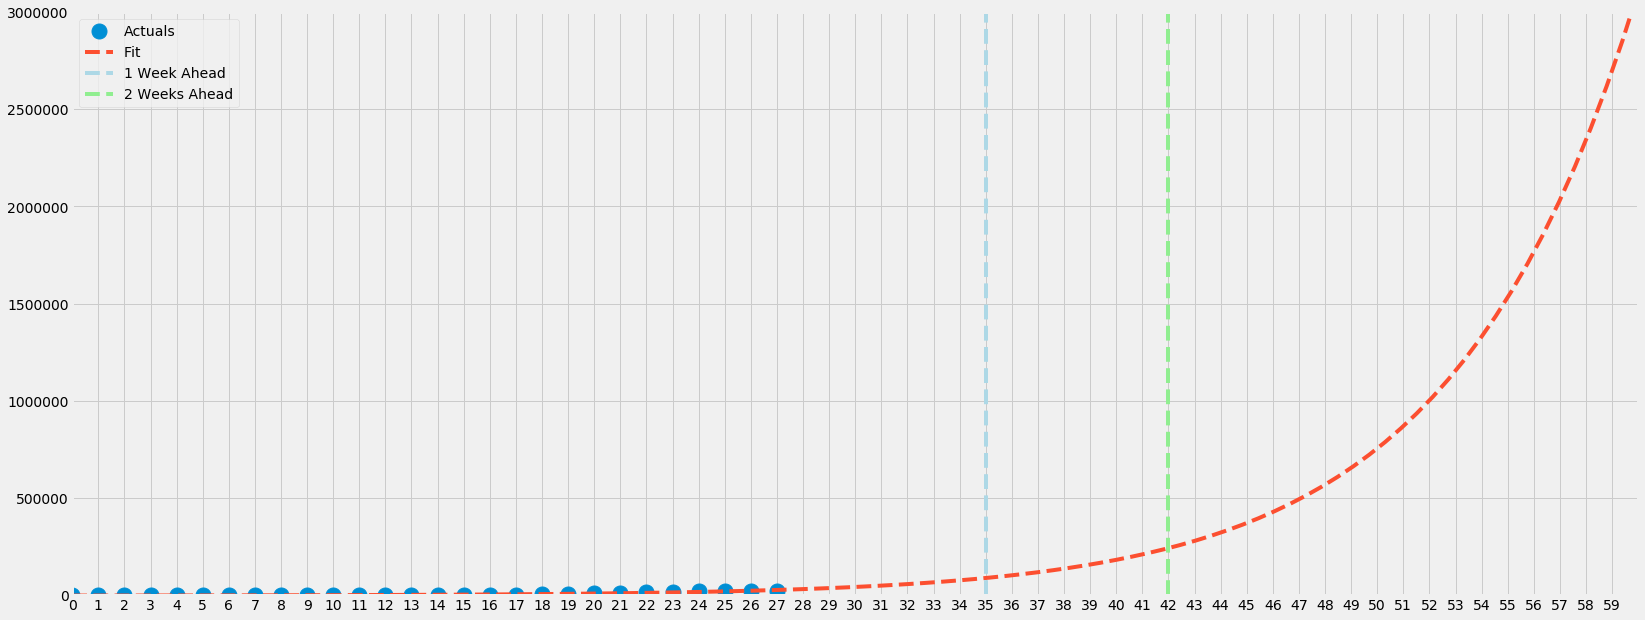

Suspected CASES
***************
a =  648.6615564085987
b =  0.1412480978511246
c =  -2061.0497967596057
R^2 = 0.9556
Next predicted data point   31,794
         7 Days from Now    88,937
        14 Days from Now    242,527


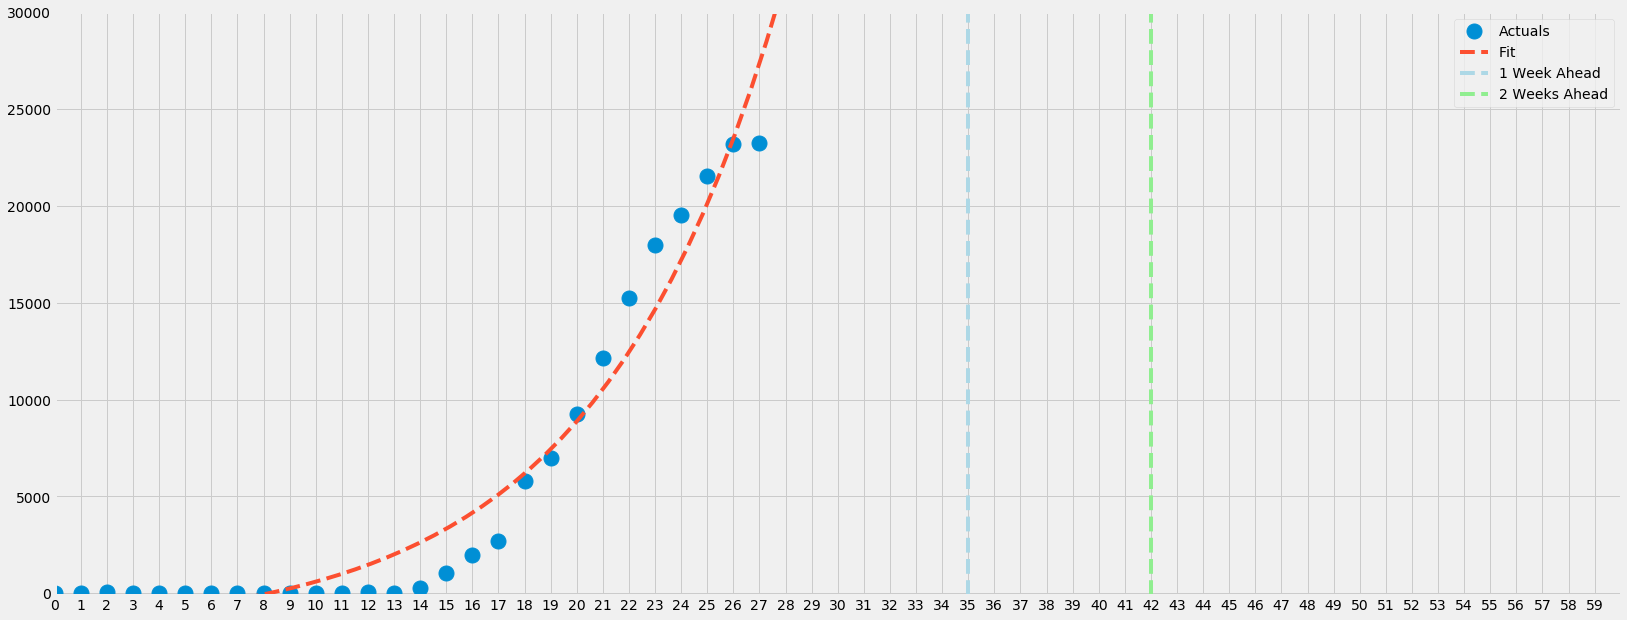

In [17]:
# test_data = 1
points = 0
length = df_sc.count()
n = length - points
print('Suspected CASES')
print('***************')
proj(df_sc,n,3000000)

print('Suspected CASES')
print('***************')
proj(df_sc,n,30000)

Daily New Cases & Fatalities


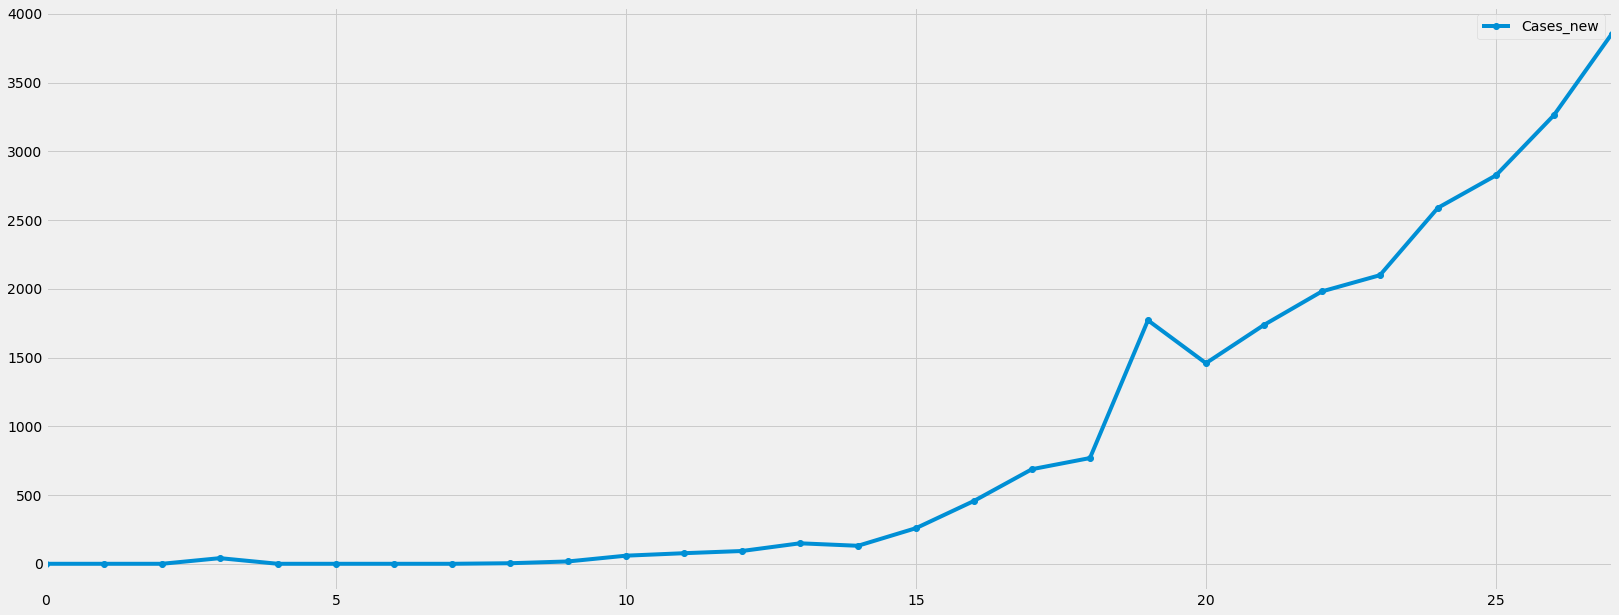

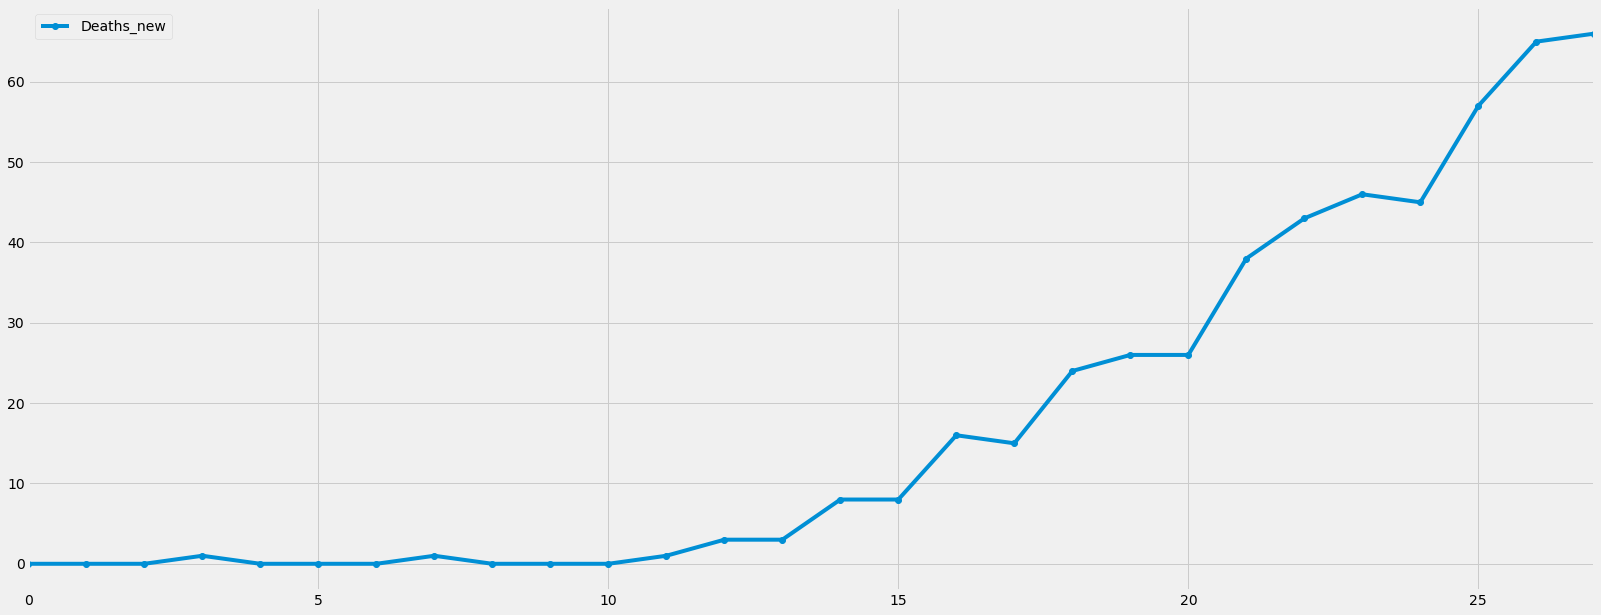

In [18]:
df=df.fillna(0)
df_cp = df['Cases_pct']
df_cn = df['Cases_new']
df_dp = df['Deaths_pct']
df_dn = df['Deaths_new']
print('Daily New Cases & Fatalities')

rcParams['figure.figsize'] = 25,10
df['Cases_new'].plot(marker='o')
plt.legend()
plt.show()
df['Deaths_new'].plot(marker='o')
plt.legend()
plt.show()

DAILY NEW CASES
***************
a =  93.2927616330655
b =  0.14069377932902072
c =  -242.61331618860143
R^2 = 0.9741
Next predicted data point   4,552
         7 Days from Now    12,594
        14 Days from Now    34,125


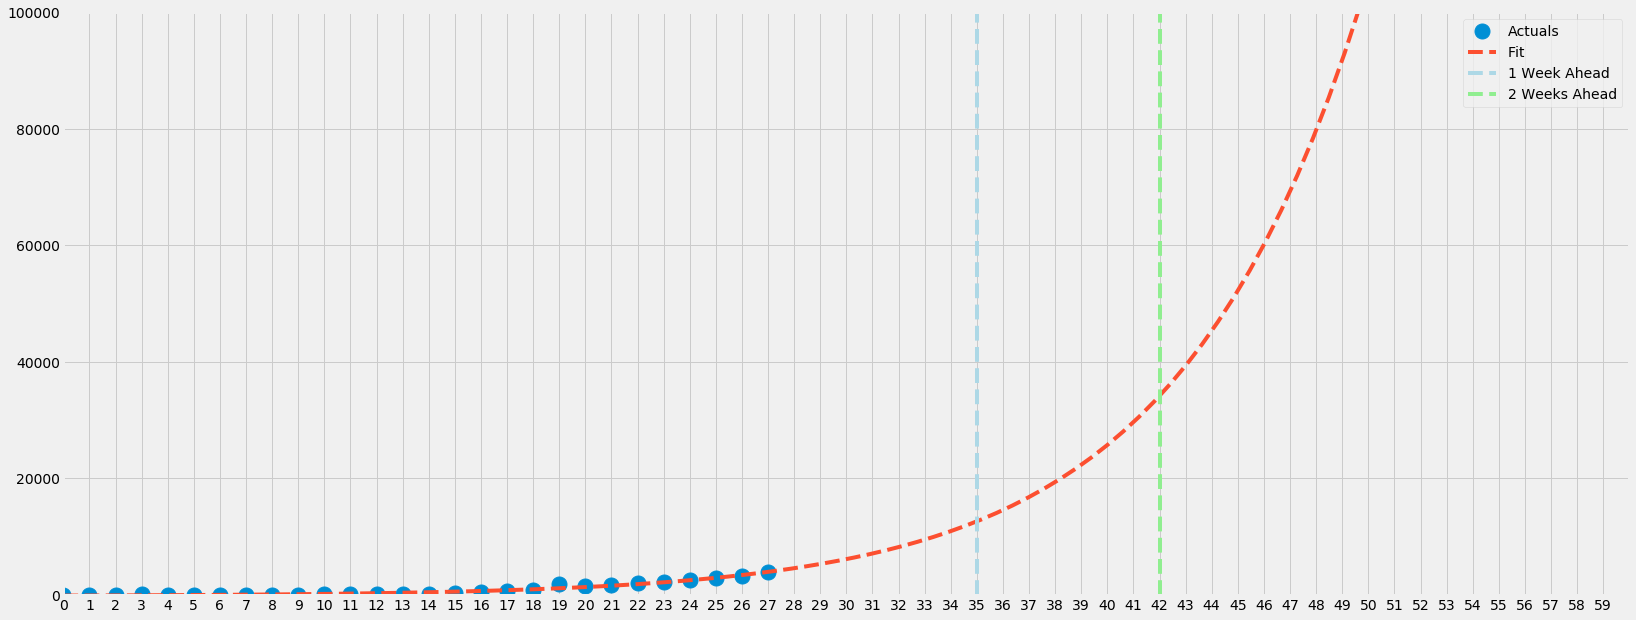

DAILY NEW CASES
***************
a =  93.2927616330655
b =  0.14069377932902072
c =  -242.61331618860143
R^2 = 0.9741
Next predicted data point   4,552
         7 Days from Now    12,594
        14 Days from Now    34,125


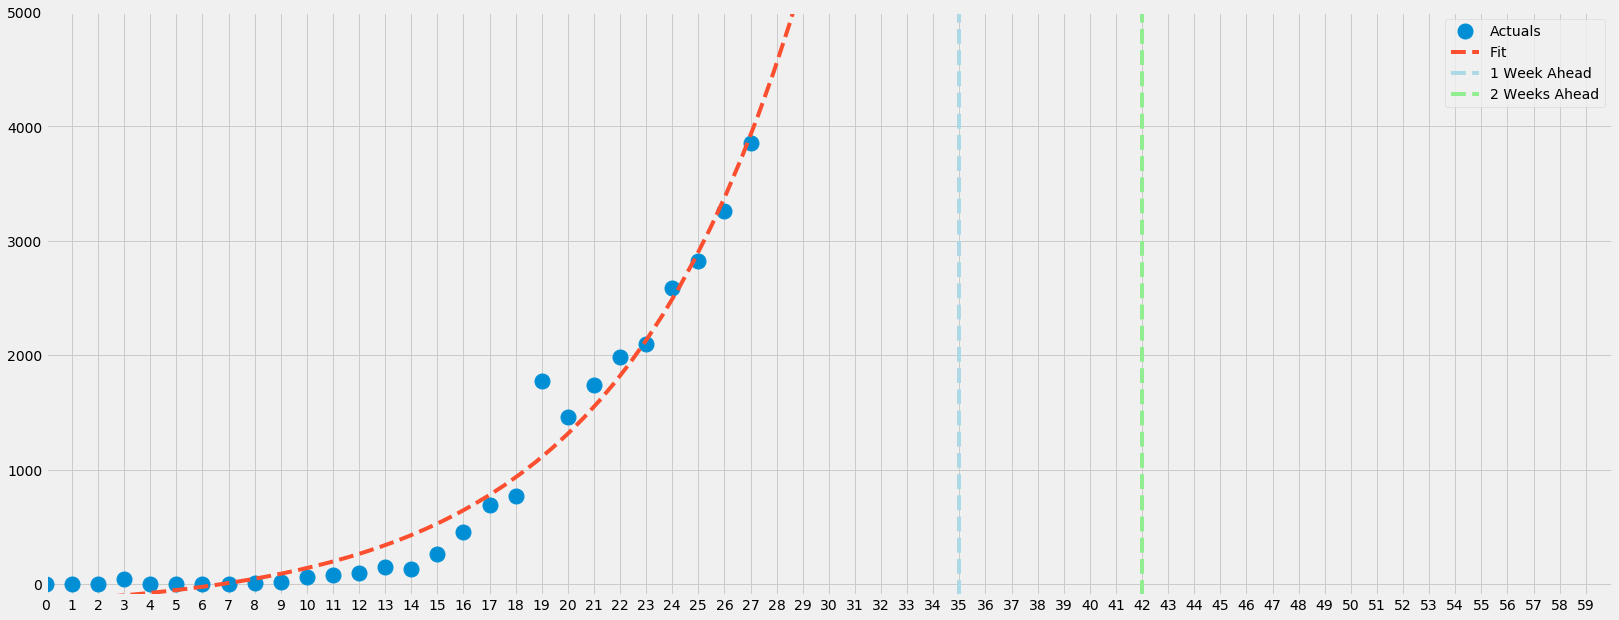

In [19]:
# test_data = 1
points = 0
length = df_cn.count()
n = length - points
print('DAILY NEW CASES')
print('***************')
proj(df_cn,n,100000)

print('DAILY NEW CASES')
print('***************')
proj(df_cn,n,5000)

DAILY NEW FATALITIES
***************
a =  3.2128513776210617
b =  0.11846247866220763
c =  -6.675978429686751
R^2 = 0.976
Next predicted data point   82
         7 Days from Now    196
        14 Days from Now    459


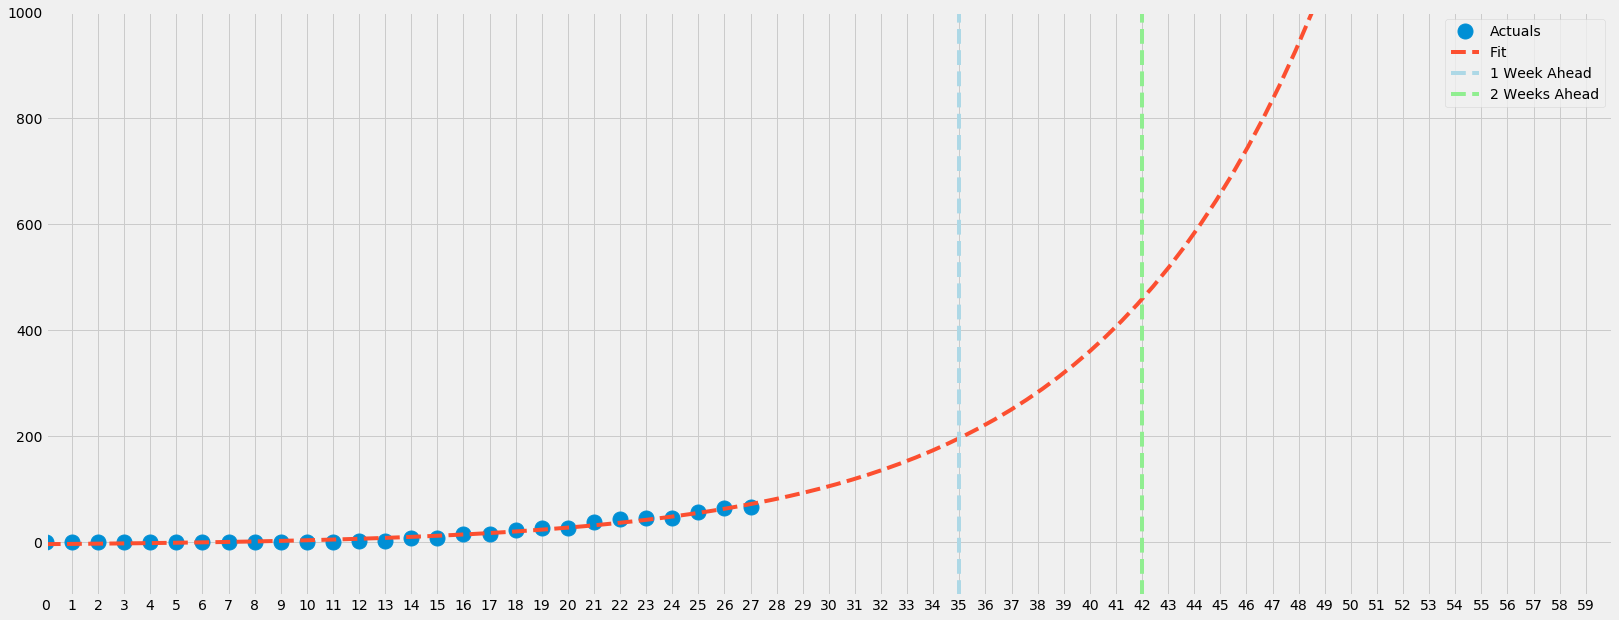

DAILY NEW FATALITIES
***************
a =  3.2128513776210617
b =  0.11846247866220763
c =  -6.675978429686751
R^2 = 0.976
Next predicted data point   82
         7 Days from Now    196
        14 Days from Now    459


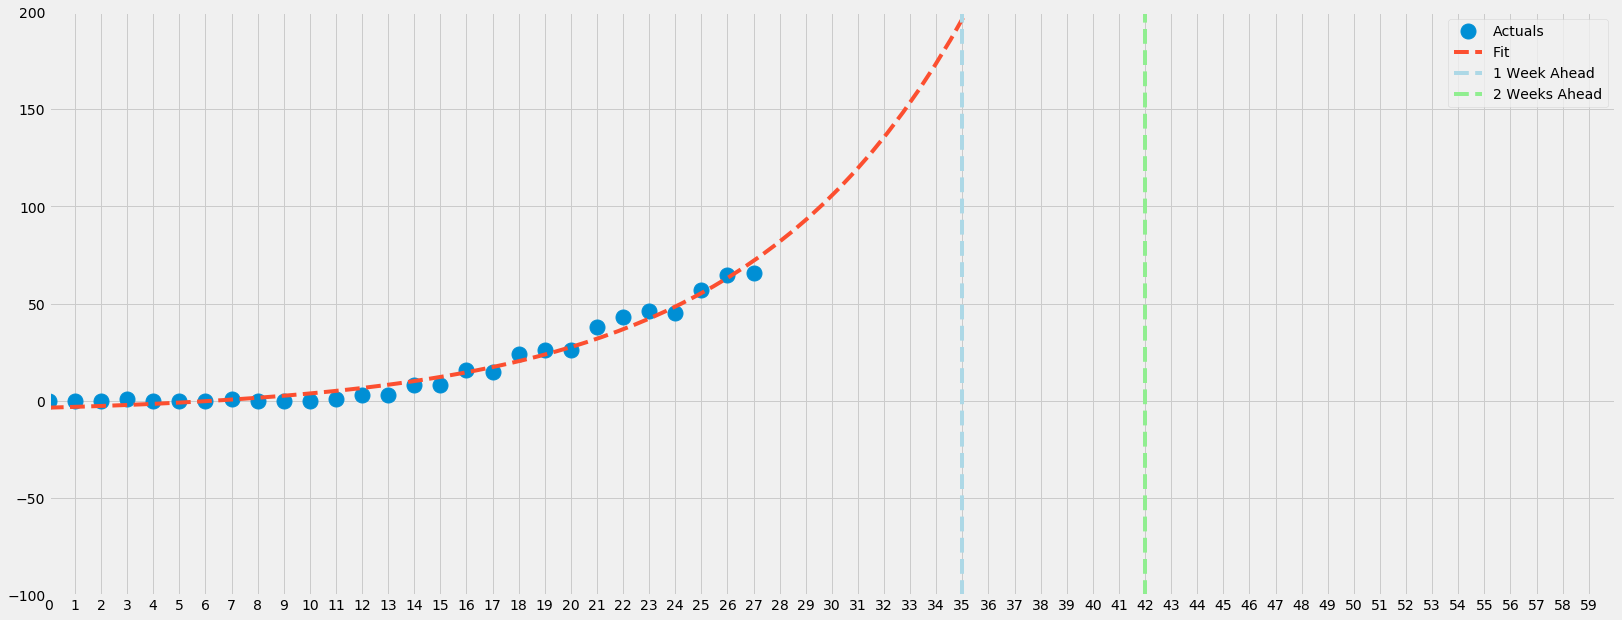

In [20]:
# test_data = 1
points = 0
length = df_dn.count()
n = length - points
print('DAILY NEW FATALITIES')
print('***************')
proj(df_dn,n,1000)
print('DAILY NEW FATALITIES')
print('***************')
proj(df_dn,n,200)

CONFIRMED CASES
***************
a =  119.41762745540434
b =  0.1992129723208497
c =  -640.4119874147902
R^2 = 0.9932
Next predicted data point   30,949
         7 Days from Now    126,759
        14 Days from Now    513,150


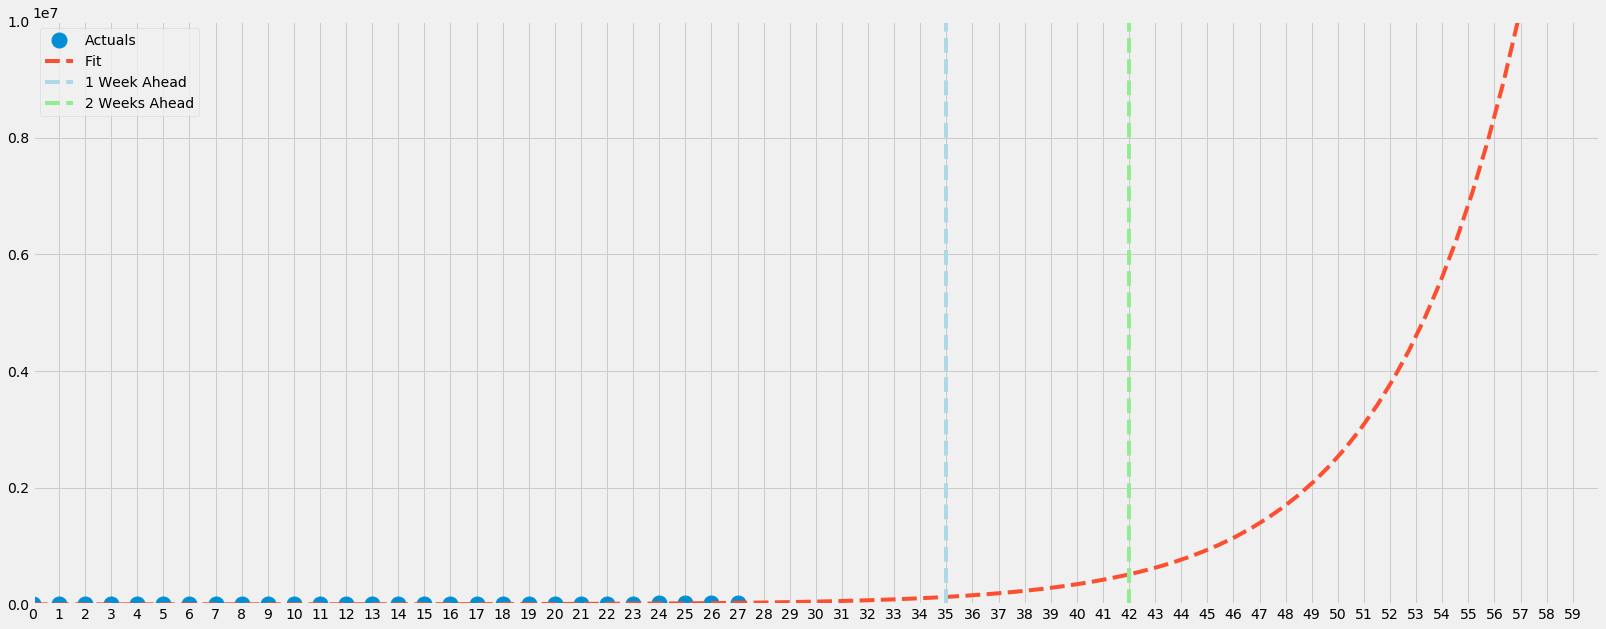

CONFIRMED CASES
***************
a =  119.41762745540434
b =  0.1992129723208497
c =  -640.4119874147902
R^2 = 0.9932
Next predicted data point   30,949
         7 Days from Now    126,759
        14 Days from Now    513,150


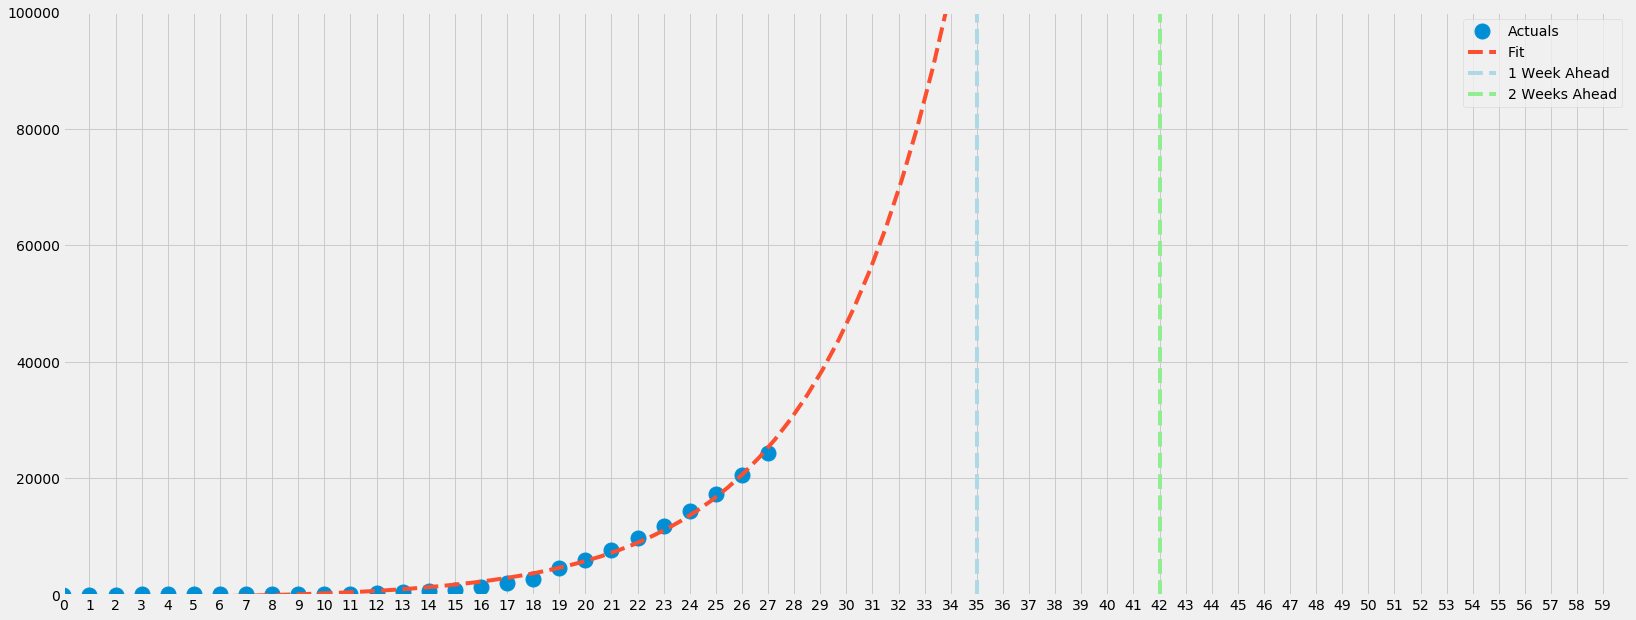

CONFIRMED CASES
***************
a =  119.41762745540434
b =  0.1992129723208497
c =  -640.4119874147902
R^2 = 0.9932
Next predicted data point   30,949
         7 Days from Now    126,759
        14 Days from Now    513,150


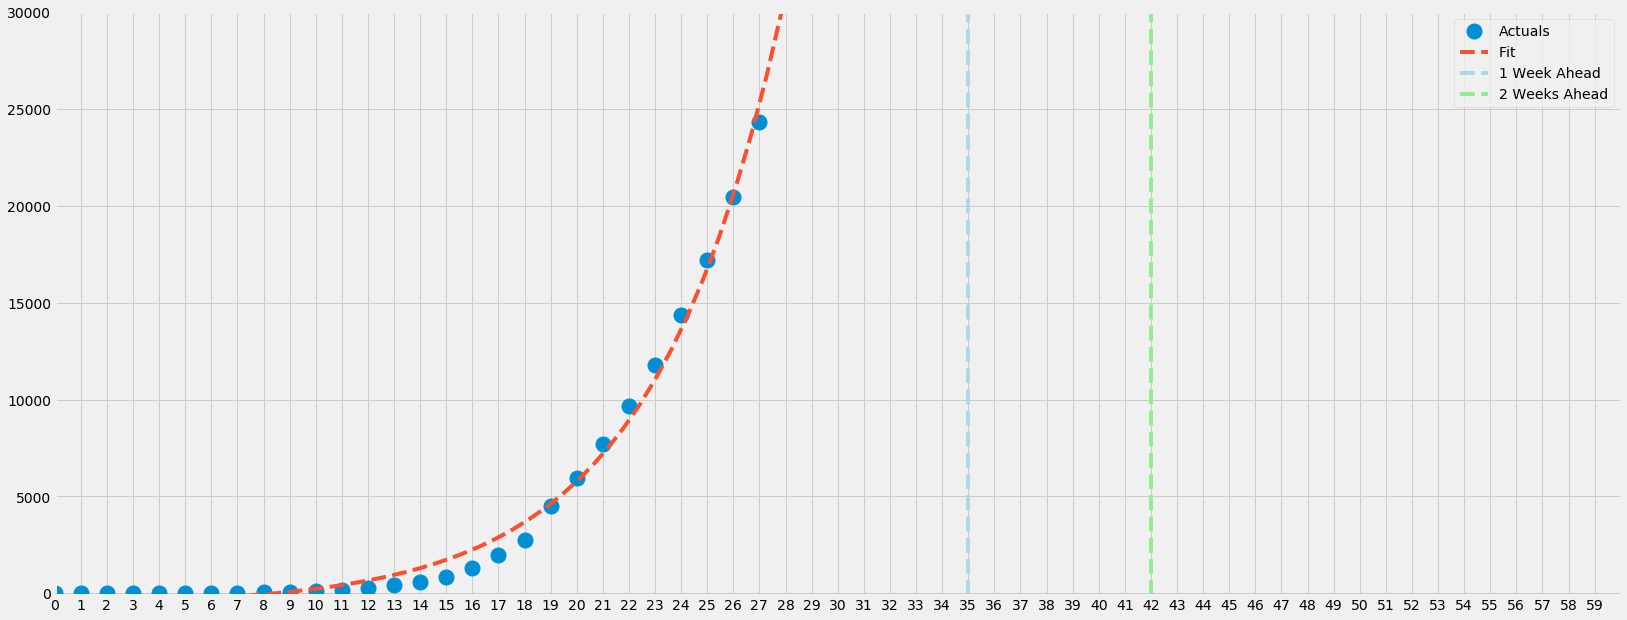

In [21]:
# test_data = 1
points = 0
length = df_cc.count()
n = length - points
print('CONFIRMED CASES')
print('***************')
proj(df_cc,n)
#Zoom-in
print('CONFIRMED CASES')
print('***************')
proj(df_cc,n,100000)
print('CONFIRMED CASES')
print('***************')
proj(df_cc,n,30000)

CONFIRMED CASES outside Mainland China
**************************************


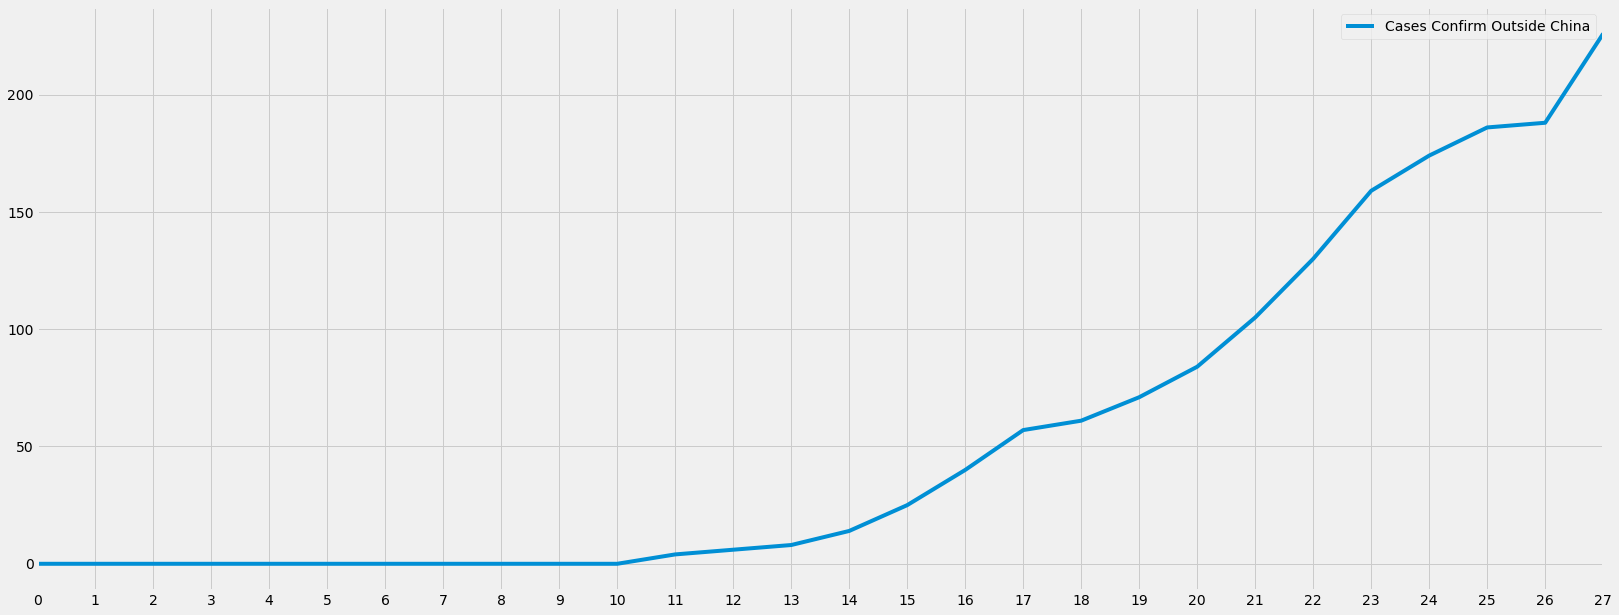

In [22]:
print('CONFIRMED CASES outside Mainland China')
print('**************************************')
df_cco.plot(xticks=df.index)
plt.legend()
plt.show()

CONFIRMED CASES outside Mainland China - Exponential Model
**********************************************************
a =  7.986339400850682
b =  0.1286674686124074
c =  -19.221358394329435
R^2 = 0.978
Next predicted data point   274
         7 Days from Now    702
        14 Days from Now    1,756


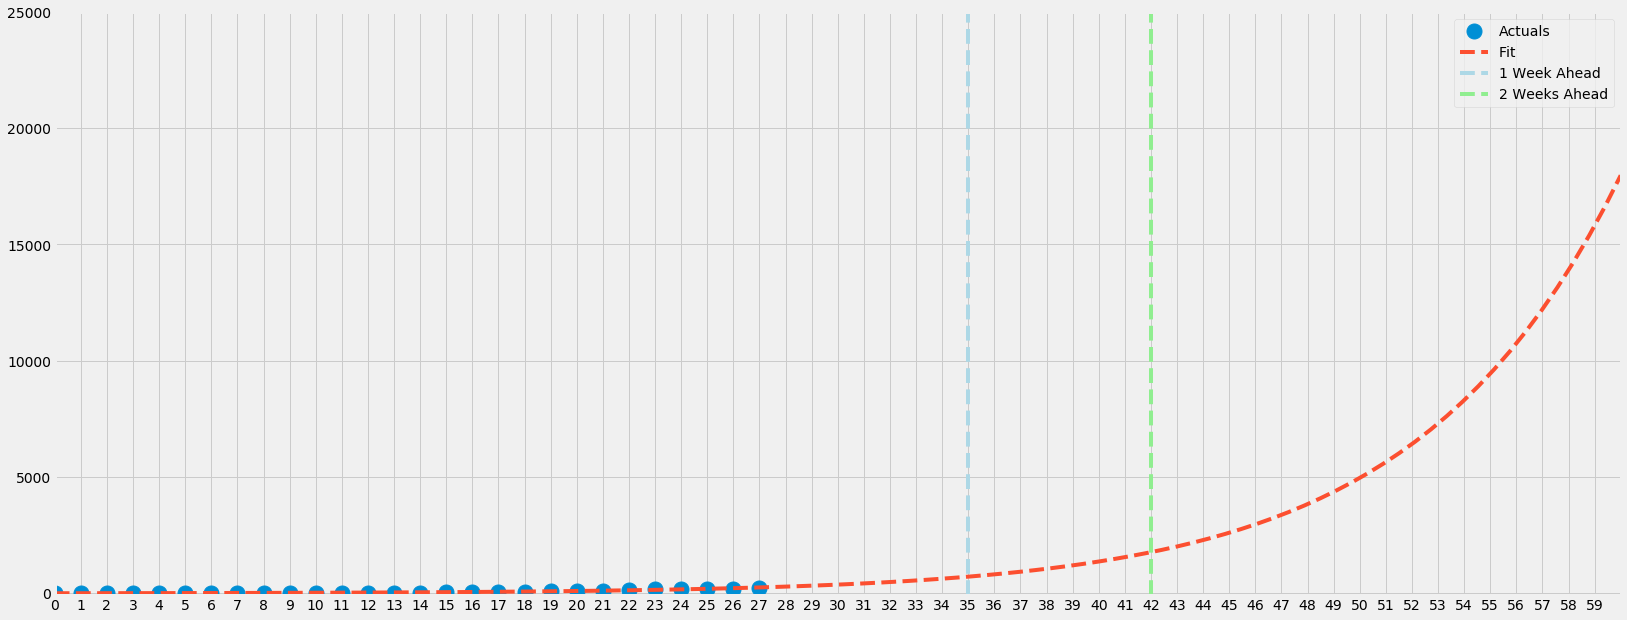

CONFIRMED CASES outside Mainland China - Exponential Model
**********************************************************
a =  7.986339400850682
b =  0.1286674686124074
c =  -19.221358394329435
R^2 = 0.978
Next predicted data point   274
         7 Days from Now    702
        14 Days from Now    1,756


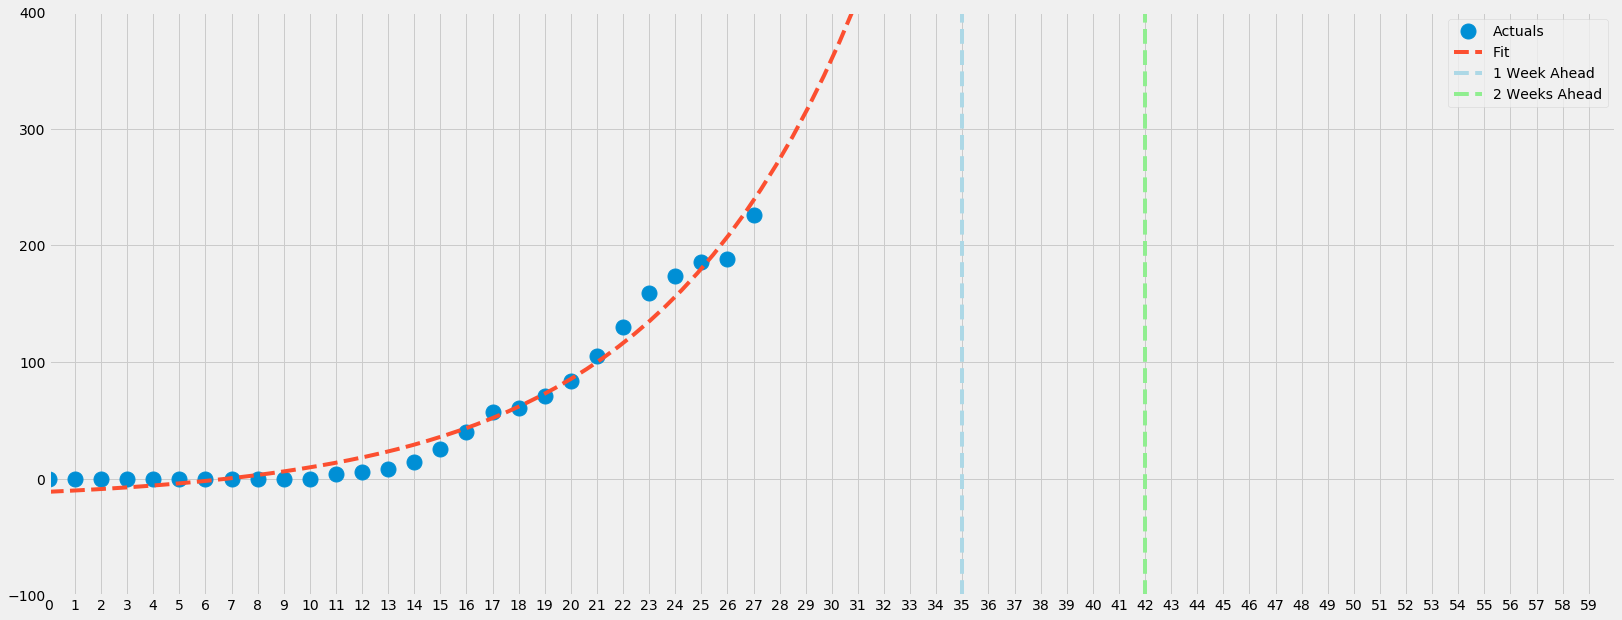

In [23]:
df_cco=df_cco.fillna(0)
# test_data = 1
points = 0
length = df_cco.count()
n = length - points
print('CONFIRMED CASES outside Mainland China - Exponential Model')
print('**********************************************************')
proj(df_cco,n,25000)
print('CONFIRMED CASES outside Mainland China - Exponential Model')
print('**********************************************************')
proj(df_cco,n,400)

RECOVERIES vs. FATALITIES Outside of China


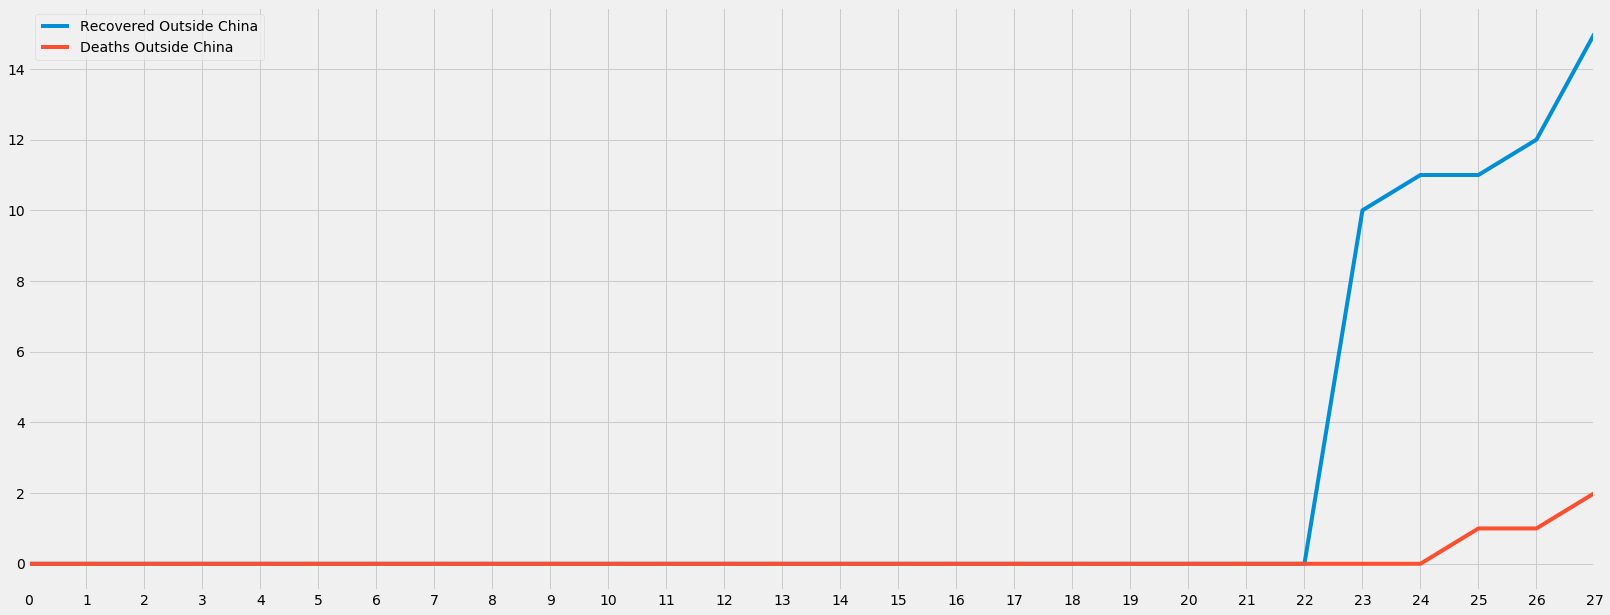

In [24]:
df_do = df['Deaths Outside China']
df_ro = df['Recovered Outside China']
print('RECOVERIES vs. FATALITIES Outside of China')
df_ro.plot(xticks=df.index)
df_do.plot(xticks=df.index)
plt.legend()
plt.show()

FATALITIES
**********
a =  3.854189268698296
b =  0.18234988368516183
c =  -15.979476102526744
R^2 = 0.9934
Next predicted data point   620
         7 Days from Now    2,263
        14 Days from Now    8,151


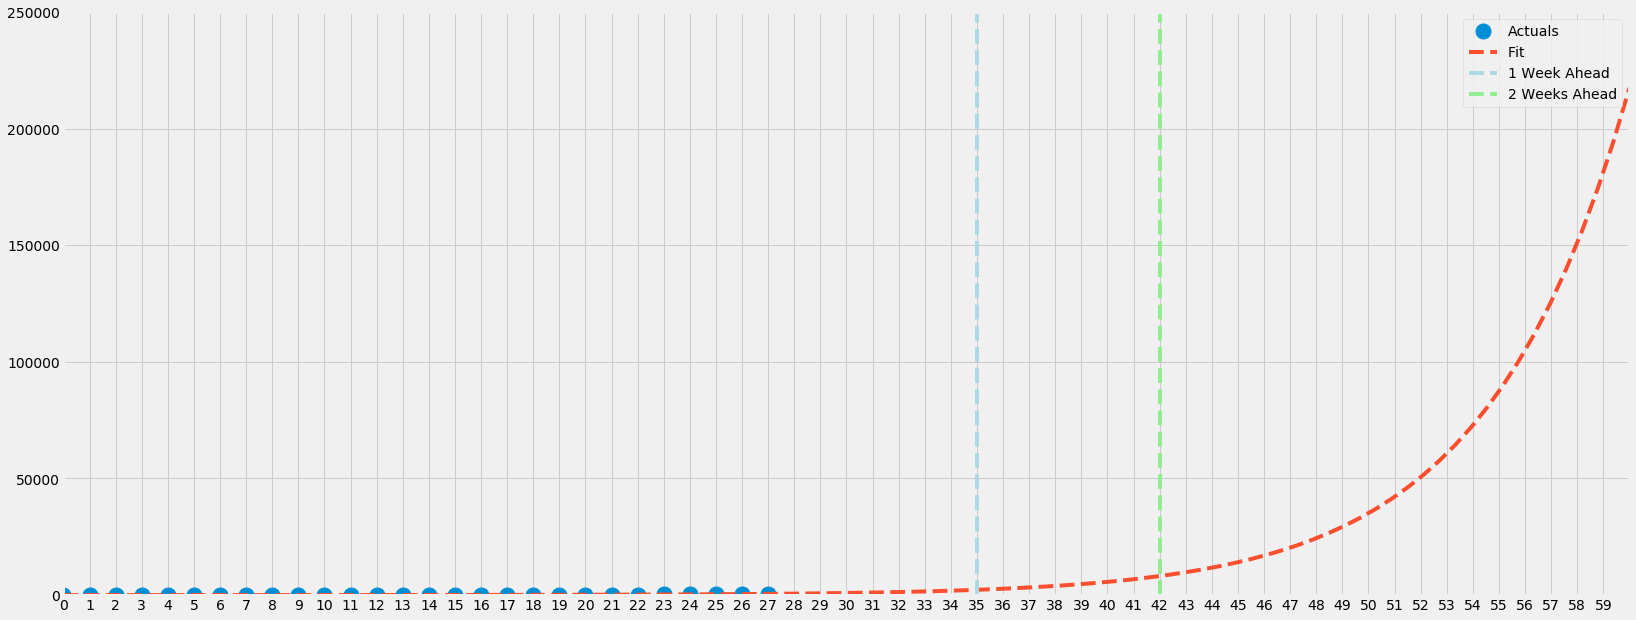

FATALITIES
**********
a =  3.854189268698296
b =  0.18234988368516183
c =  -15.979476102526744
R^2 = 0.9934
Next predicted data point   620
         7 Days from Now    2,263
        14 Days from Now    8,151


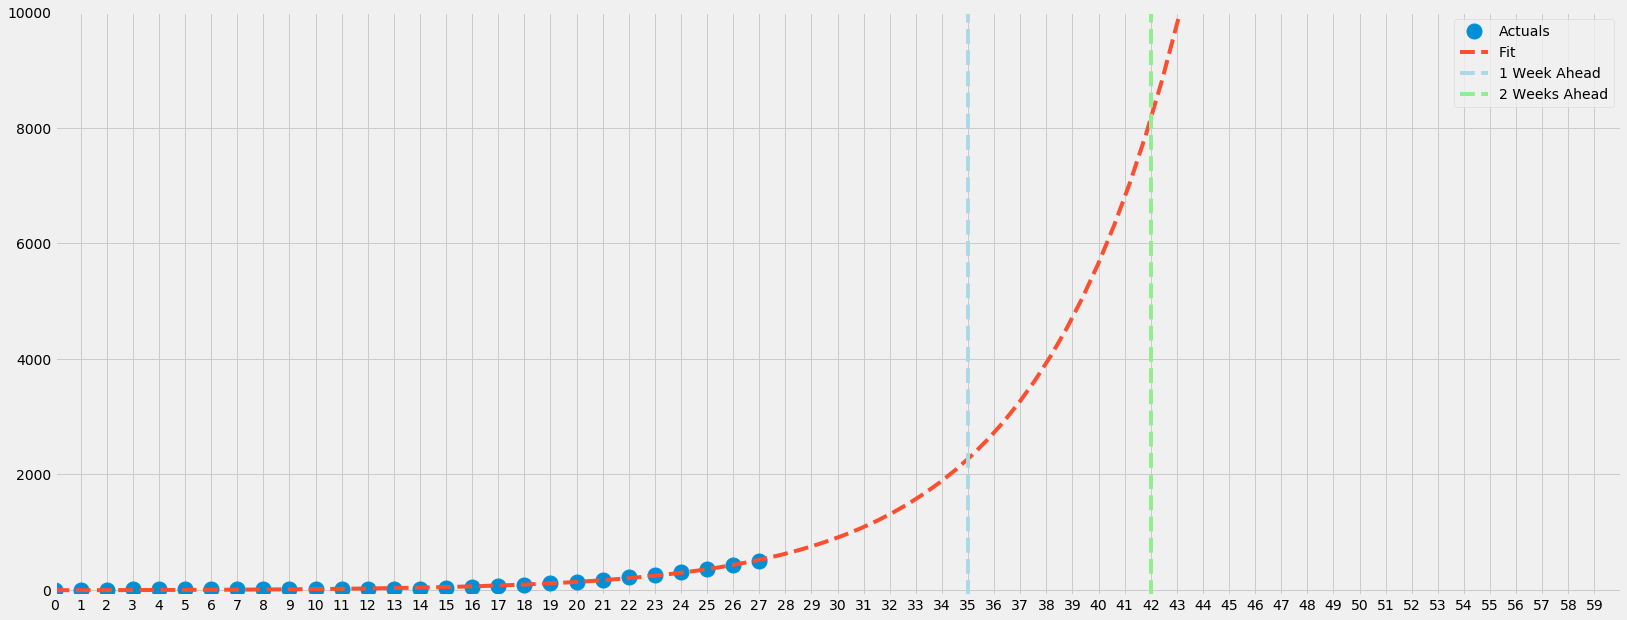

FATALITIES
**********
a =  3.854189268698296
b =  0.18234988368516183
c =  -15.979476102526744
R^2 = 0.9934
Next predicted data point   620
         7 Days from Now    2,263
        14 Days from Now    8,151


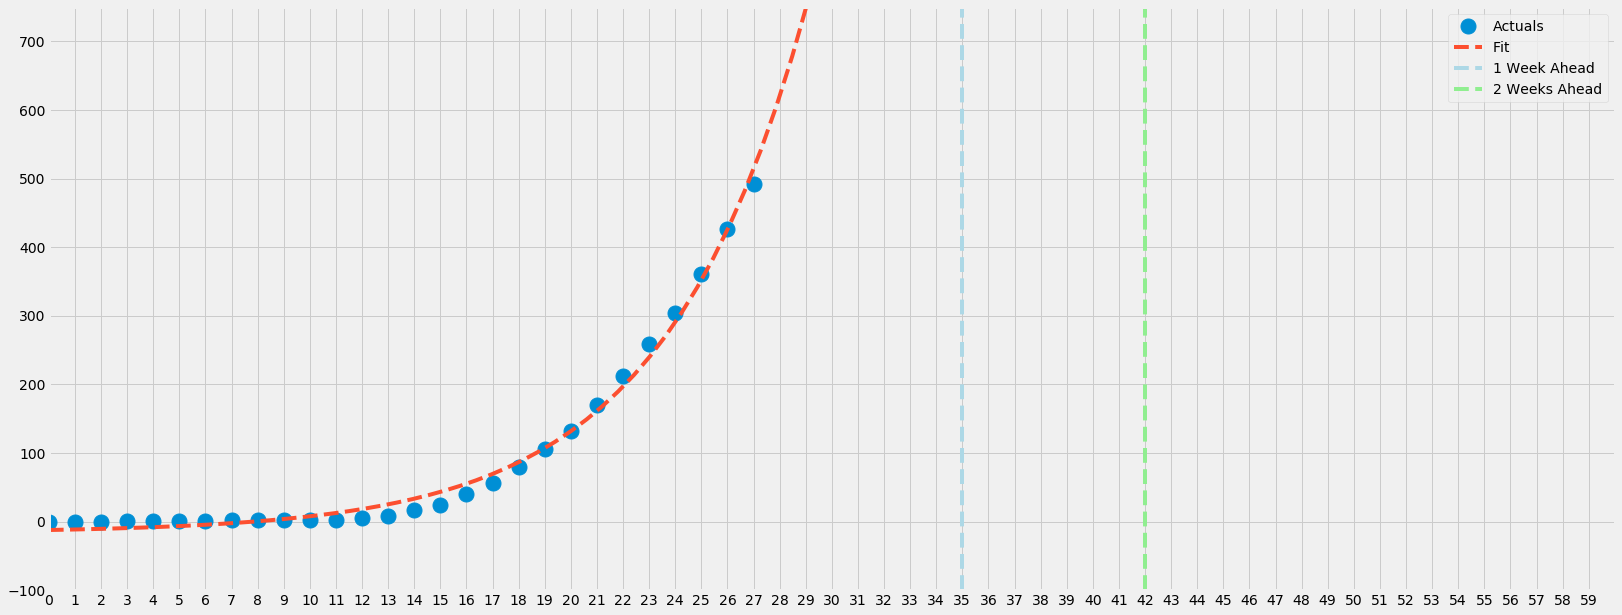

In [25]:
# test_data = 1
points = 0
length = df_d.count()
print('FATALITIES')
print('**********')
n = length - points
proj(df_d,n, 250000)
print('FATALITIES')
print('**********')
proj(df_d,n, 10000)
print('FATALITIES')
print('**********')
proj(df_d,n, 750)

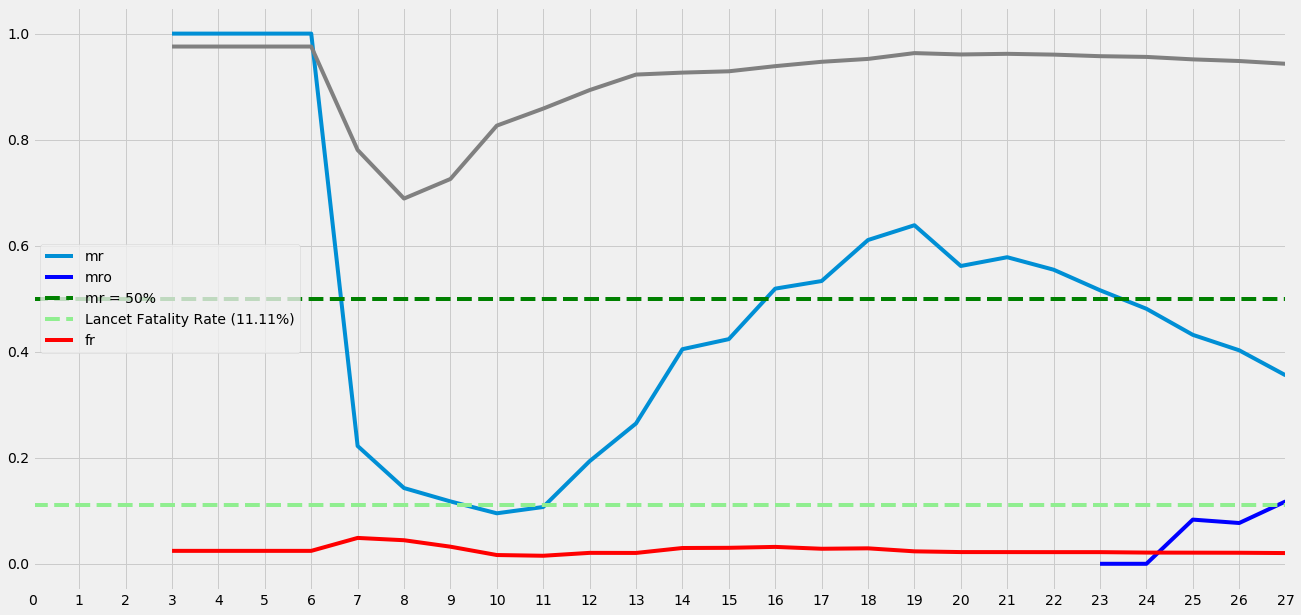

Outcomes Pending in China = 94%
MR Based Fatalities =     8,647
Lancet Based Fatalities = 2,703
MRO Based::Outside China = 27
Current:                       FR  =  2%
                               MR  = 36%
                               MRO = 12%
Reference [RED Dot] from Lancet Study 11%


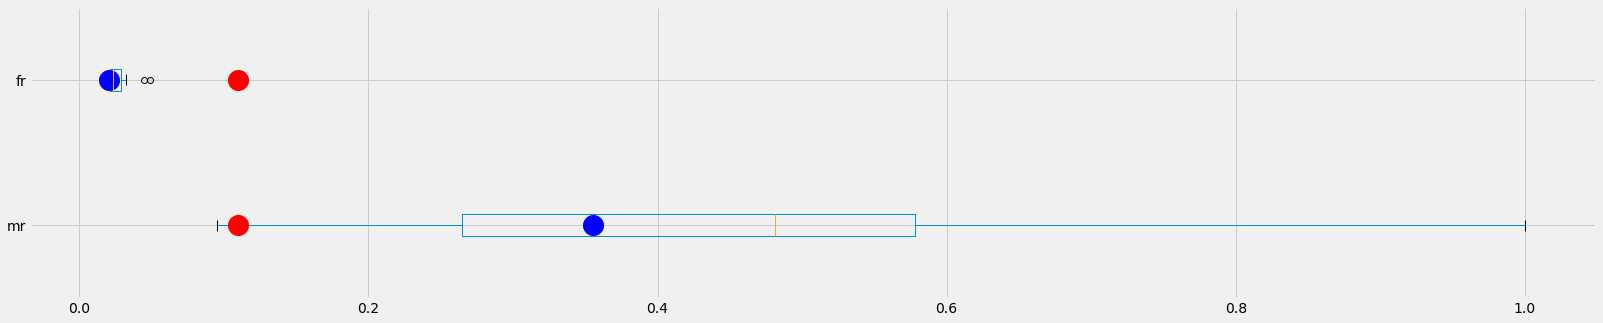

In [29]:
# MR % = Fatalities / (Fatalities + Recovered)
rcParams['figure.figsize'] = 20,10

df['mr'] = df.Deaths/(df.Deaths + df.Recovered)
df.mr.plot()
df['mro'] = df['Deaths Outside China']/(df['Deaths Outside China'] + df['Recovered Outside China'])
df.mro.plot(color='b')

# FR % = Fatalities / Confirmed Cases
df['fr'] = df.Deaths/(df['Cases Confirmed'])
plt.axhline(y=0.5, color='g', linestyle='--', label = 'mr = 50%')
plt.axhline(y=11/99, color='lightgreen', linestyle='--', label = 'Lancet Fatality Rate (11.11%)')
df.fr.plot(xticks=df.index, color='r')
plt.legend()

#Pending Outcomes
df['po'] = (df['Cases Confirmed'] - df['Deaths'] - df['Recovered'])/df['Cases Confirmed'] 
df['po'].plot(color='grey', label = 'Pending Outcomes')

plt.show()
print('Outcomes Pending in China = {:0.0%}'.format(df.po.tail(1).values[0]))
print('MR Based Fatalities =     {:,.0f}'.format(df_cc.tail(1).values[0]*df.mr.tail(1).values[0]))
print('Lancet Based Fatalities = {:,.0f}'.format(df_cc.tail(1).values[0]*11/99))
print('MRO Based::Outside China = {:,.0f}'.format(df_cco.tail(1).values[0]*df.mro.tail(1).values[0]))


#Boxplots

b=df.fr[len(df)-1]
print('Current:                       FR  =  {:.0%}'.format(b))
a=df.mr[len(df)-1]
print('                               MR  = {:.0%}'.format(a))
print('                               MRO = {:,.0%}'.format(df.mro.tail(1).values[0]))
print('Reference [RED Dot] from Lancet Study {:.0%}'.format(11/99))

rcParams['figure.figsize'] = 25,5
df.boxplot(column=['mr','fr'], vert = False)
plt.plot(a, [1], marker='o', markersize=20, color="blue")
plt.plot(b, [2], marker='o', markersize=20, color="blue")
plt.plot(.11, [1], marker='o', markersize=20, color="Red")
plt.plot(.11, [2], marker='o', markersize=20, color="Red")
plt.show()

Reference Rates: https://en.wikipedia.org/wiki/List_of_human_disease_case_fatality_rates

<b>Tableau Charts</b><br>
Tableau Charts and Forecasts built using Tableau are available on the URL:<br>
https://public.tableau.com/profile/sm.tx#!/vizhome/nCov19-v2/CasesnFatalitiesDailyDelta <br>
The built-in forecasting algorithms in Tableau Public are fairly simple and less accurate than SciPy. 